In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import os.path as op

In [2]:
def get_confounds_list(DATA_PATH, dataset):
    """Finds all the confounds files in a specific dataset.

    Parameters
    ----------
    DATA_PATH : string
        Path to the main data folder, that contains all the datasets.
    dataset : string
        Name of the dataset to fetch. Can be "friends", "hcp-rest",
        "hcp-gamble", "hcp-motor" or "gamepad".

    Returns
    -------
    list
        A list of paths to all the confounds.tsv files of a dataset.

    """
    confounds_pattern = "confounds_timeseries.tsv"
    dataset_pattern = {
        "Rest": "task-restingstate",
        "Gambling": "task-gambling",
        "Motor": "task-motor",
        "Shinobi": "task-shinobi",
        "Emotion": "task-emotion",
        "Social": "task-social",
        "Relational": "task-relational",
        "Language": "task-language",
        
    }
    if dataset == 'Shinobi':
        dataset_folder = "shinobi.fmriprep"
    else:
        dataset_folder = "hcptrt.fmriprep"
    file_list = []
    for folder, sub_folders, files in os.walk(op.join(DATA_PATH, dataset_folder)):
        for file in files:
            if confounds_pattern in file or "confounds_part-mag_timeseries.tsv" in file:
                if dataset_pattern[dataset] in file:
                    if dataset == "friends":
                        if int(file.split("_")[2].split("-")[1][2]) <= 4:
                            print(file)
                            file_list.append(os.path.join(folder, file))
                    else:
                        file_list.append(os.path.join(folder, file))
    return file_list


def build_FD_dataframe(DATA_PATH, dataset_list, metric=None):
    """Build a dataframe that contains FD values across various CNeuromod datasets.

    Parameters
    ----------
    dataset_list : list of strings
        List of the datasets to extract FD values from.
    metric : str
        Can be "mean", "median" or "variance". Determines which descriptive
        metrics to use across runs.

    Returns
    -------
    pandas.DataFrame
        A dataframe containing FD values of the relevant CNeuromod datasets.

    """
    fd_values = []
    dataset_name = []
    subject_name = []
    sess_name = []
    run_name = []
    n_slices = []

    for dataset in dataset_list:
        file_list = get_confounds_list(DATA_PATH, dataset=dataset)
        if metric is not None:
            for file in tqdm(file_list):
                data = pd.read_csv(file, sep="\t")
                if metric == "mean":
                    fd_values.append(np.nanmean(data["framewise_displacement"]))
                elif metric == "median":
                    fd_values.append(np.nanmedian(data["framewise_displacement"]))
                elif metric == "variance":
                    fd_values.append(np.nanvar(data["framewise_displacement"]))
                elif metric == "max":
                    fd_values.append(np.max(data["framewise_displacement"]))
                dataset_name.append(dataset)
                subject_name.append(file.split("/")[-1].split("_")[0])
                sess_name.append(file.split("/")[-1].split("_")[1])
                run_name.append(file.split("/")[-1].split("_")[3])
                n_slices.append(len(data["framewise_displacement"]))
        else:
            for file in tqdm(file_list):
                data = pd.read_csv(file, sep="\t")
                for val in data["framewise_displacement"]:
                    fd_values.append(val)
                    dataset_name.append(dataset)
                    subject_name.append(file.split("/")[-1].split("_")[0])
                    sess_name.append(file.split("/")[-1].split("_")[1])
                    run_name.append(file.split("/")[-1].split("_")[3])
                    n_slices.append(len(data["framewise_displacement"]))
    dataframe = pd.DataFrame(
        {"FD": fd_values, "dataset": dataset_name, "subject": subject_name,
         "session": sess_name, "run": run_name, "n_slices": n_slices}
    )
    return dataframe

In [3]:
# Set constants
DATA_PATH = "/media/hyruuk/YH_storage/DATA/neuromod/shinobi_data"
dataset_list = ["Shinobi", "Rest", "Motor", "Gambling",  "Emotion", "Social", "Relational", "Language"]
metric = "median"

# Generate/load FD dataframe
df_fname = op.join("../data/processed/", f"fd_dataframe_{metric}.csv")
if not op.isfile(df_fname):
    FD_dataframe = build_FD_dataframe(DATA_PATH, dataset_list, metric=metric)
    FD_dataframe.to_csv(df_fname, index=False)
else:
    FD_dataframe = pd.read_csv(df_fname)

FD_dataframe = FD_dataframe[FD_dataframe["subject"] != "sub-03"]
FD_dataframe = FD_dataframe[FD_dataframe["subject"] != "sub-05"]

In [4]:
import ptitprince
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
import pandas as pd


def make_whole_FD_plot(FD_dataframe, figtitle):
    # Set params
    dx = "dataset"
    dy = "FD"
    dhue = "dataset"
    ort = "v"
    sigma = 0.15
    spot_names = string.ascii_uppercase[:5]

    # Determine order of datasets by descending average FD
    order = (
        FD_dataframe
        .groupby(dx)[dy]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    # Convert x variable to categorical for consistent ordering
    FD_dataframe[dx] = pd.Categorical(FD_dataframe[dx], categories=order, ordered=True)

    # Define custom color mapping
    palette = sns.color_palette("Set2")
    palette_dark = sns.color_palette("Dark2")
    colors_dict = {
        'Shinobi': palette[1],
        'Rest': palette[0],
        'Gambling': palette_dark[2],
        'Motor': palette_dark[3],
        'Language': palette_dark[4],
        'Social': palette_dark[5],
        'Relational': palette_dark[6],
        'Emotion': palette_dark[7],
    }
    
    # Make figure
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(figtitle, y=1, fontsize=24)
    
    # All subjects plot
    gs_outer = fig.add_gridspec(2, 4)
    ax_allsubj = fig.add_subplot(gs_outer[:, 2:])
    ax_allsubj = ptitprince.RainCloud(
        x=dx,
        y=dy,
        hue=dhue,
        data=FD_dataframe,
        palette=colors_dict,
        order=order,
        bw=sigma,
        width_viol=1,
        ax=ax_allsubj,
        orient=ort,
        alpha=0.65,
        offset=-0.05,
        move=0.2,
        width_box=0.1,
    )
    ax_allsubj.get_legend().remove()
    ax_allsubj.set_title("All subjects pooled", fontweight="bold", fontsize=18)
    ax_allsubj.set_xlabel("")
    ax_allsubj.set_ylabel("FD", fontsize=16)
    ax_allsubj.tick_params(axis='y', labelsize=14)
    # Color and style x-tick labels
    for lbl in ax_allsubj.get_xticklabels():
        txt = lbl.get_text()
        lbl.set_color(colors_dict.get(txt, 'black'))
        lbl.set_fontsize(16)
        if txt == 'Shinobi':
            lbl.set_fontweight('bold')
        lbl.set_rotation(45)
    # Add spot name
    ax_allsubj.text(-0.08, 1.04, spot_names[-1], transform=ax_allsubj.transAxes, size=22, weight='bold')

    # Single subject plots
    axes_persubj = [
        fig.add_subplot(gs_outer[0, 0]),
        fig.add_subplot(gs_outer[0, 1]),
        fig.add_subplot(gs_outer[1, 0]),
        fig.add_subplot(gs_outer[1, 1])
    ]
    
    subjects = np.unique(FD_dataframe["subject"])
    for i, ax in enumerate(axes_persubj):
        subj_dataframe = FD_dataframe[FD_dataframe["subject"] == subjects[i]]

        ax = ptitprince.RainCloud(
            x=dx,
            y=dy,
            hue=dhue,
            data=subj_dataframe,
            palette=colors_dict,
            order=order,
            bw=sigma,
            width_viol=1,
            ax=ax,
            orient=ort,
            alpha=0.65,
            offset=-0.05,
            move=0.2,
            width_box=0.1,
        )
        ax.get_legend().remove()
        ax.set_title(subjects[i], fontweight="bold", fontsize=16)
        ax.set_ylim([0, 0.3])
        ax.set_xlabel("")
        ax.set_ylabel("FD", fontsize=12)
        # Style x-tick labels per subject
        for lbl in ax.get_xticklabels():
            txt = lbl.get_text()
            lbl.set_color(colors_dict.get(txt, 'black'))
            lbl.set_fontsize(14)
            if txt == 'Shinobi':
                lbl.set_fontweight('bold')
            lbl.set_rotation(45)
        # Add spot name
        ax.text(-0.1, 1.1, spot_names[i], transform=ax.transAxes, size=22, weight='bold')
    plt.tight_layout()
    return fig


/home/hyruuk/mambaforge/envs/shinobi_env/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/hyruuk/mambaforge/envs/shinobi_env/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/hyruuk/mambaforge/envs/shinobi_env/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

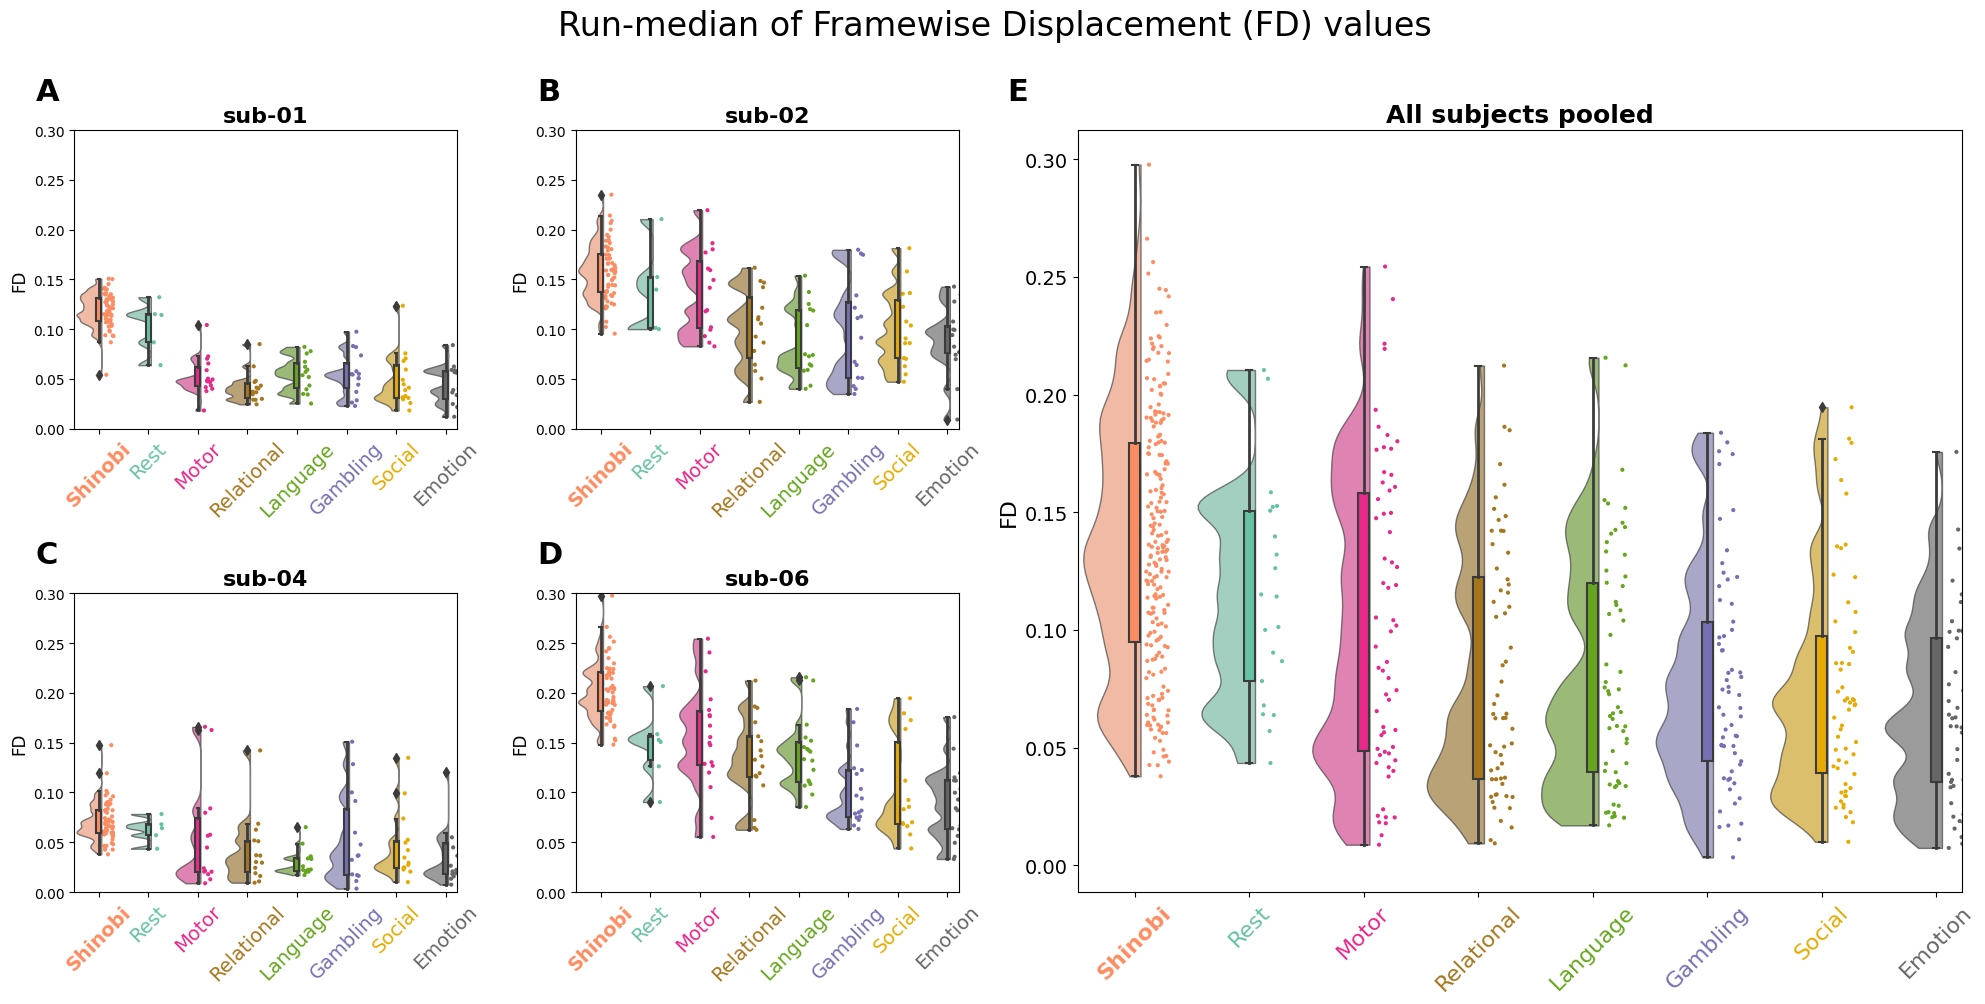

In [5]:
fig = make_whole_FD_plot(FD_dataframe, 'Run-median of Framewise Displacement (FD) values')
fig.savefig("../reports/figures_final/A1_framewise_displacement.png", dpi=300, bbox_inches='tight')

In [63]:
FD_dataframe['dataset'].unique()

array(['Shinobi', 'Rest', 'Motor', 'Gamble', 'Emotion', 'Social',
       'Relational', 'Language'], dtype=object)

In [6]:
FD_dataframe

,FD,dataset,subject,session,run,n_slices
0,0.135318,Shinobi,sub-01,ses-002,run-1,451
1,0.150251,Shinobi,sub-01,ses-002,run-2,434
2,0.132756,Shinobi,sub-01,ses-002,run-3,420
3,0.145245,Shinobi,sub-01,ses-002,run-4,422
4,0.131028,Shinobi,sub-01,ses-003,run-1,426
...,...,...,...,...,...,...
778,0.155176,Language,sub-06,ses-009,run-2,159
779,0.122728,Language,sub-06,ses-010,run-1,159
780,0.111934,Language,sub-06,ses-012,run-1,159
781,0.168059,Language,sub-06,ses-012,run-2,159
